# Homework II - Report

Cecília Correia, 106827
<br>Patrícia Gameiro, 107245

## Programming and critical analysis [7v]

**Consider the heart-disease.csv dataset available at the course webpage’s homework tab.
Using `sklearn`, apply a 5-fold stratified cross-validation with shuffling (`random_state=0`) for the
assessment of predictive models along this section.**

### 1) 
**Compare the performance of a 𝑘𝑁𝑁 with 𝑘 = 5 and a naïve Bayes with Gaussian assumption (consider all remaining parameters as default):**

a. [1.0v] **Plot two boxplots with the fold accuracies for each classifier. Is there one more stable than the other regarding performance? Why do you think that is the case? Explain.**

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [96]:
df = pd.read_csv("./data/heart-disease.csv")

X = df.drop("target", axis = 1)
y = df["target"]

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

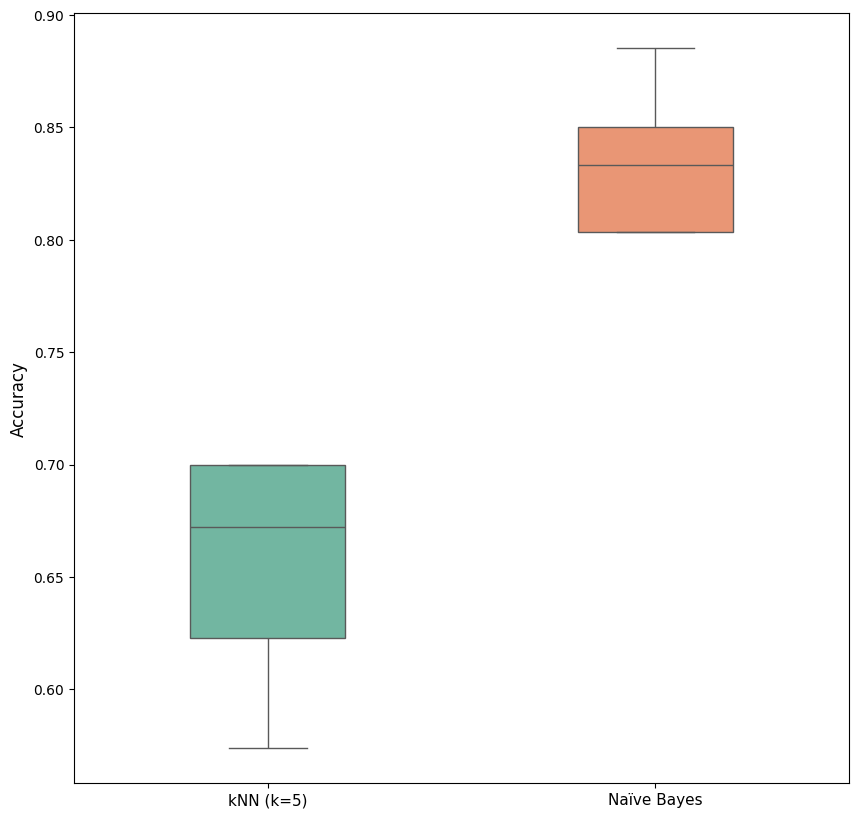

In [97]:
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
naive_bayes_classifier = GaussianNB()

knn_scores = cross_val_score(knn_classifier, X, y.tolist(), cv = skf, scoring='accuracy')
naive_bayes_scores = cross_val_score(naive_bayes_classifier, X, y.tolist(), cv = skf, scoring = 'accuracy')

plt.figure(figsize=(10, 10))

sns.boxplot(data = [knn_scores, naive_bayes_scores], palette = "Set2", width = 0.4)
plt.xticks([0, 1], ["kNN (k=5)", "Naïve Bayes"], fontsize = 11)
plt.ylabel("Accuracy", fontsize = 12)

plt.show()

The Naïve Bayes classifier shows more consistent performance, with a narrower interquartile range (IQR) and less variability in accuracy. This stability likely arises from its assumption of feature independence and Gaussian distribution, which makes it less sensitive to noise and data imbalances. Since Naïve Bayes operates under these strong assumptions, it maintains consistent behavior across different datasets. \
In contrast, the kNN classifier is more sensitive to the dataset's distribution and the selection of neighbors, which leads to greater fluctuations in accuracy. Its reliance on local relationships makes it more prone to changes, as these can shift based on the data. This sensitivity is reflected in the wider IQR and larger spread in kNN's accuracy, resulting in less stability compared to Naïve Bayes.

b. [1.0v] **Report the accuracy of both models, this time scaling the data with a Min-Max scaler before training the models. Explain the impact that this preprocessing step has on the performance of each model, providing an explanation for the results.**

In [98]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [99]:
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

min_max_scaler = MinMaxScaler()
X_scaled_minmax = X.copy()
X_scaled_minmax[numeric_features] = min_max_scaler.fit_transform(X[numeric_features])

knn_scores_minmax = cross_val_score(knn_classifier, X_scaled_minmax, y, cv = skf, scoring = "accuracy")
gnb_scores_minmax = cross_val_score(naive_bayes_classifier, X_scaled_minmax, y, cv = skf, scoring = "accuracy")

print(f"Naïve Bayes accuracy = {np.mean(gnb_scores_minmax):.2f}, {np.std(gnb_scores_minmax):.2f}")
print(f"kNN accuracy = {np.mean(knn_scores_minmax):.2f}, {np.std(knn_scores_minmax):.2f}")

Naïve Bayes accuracy = 0.84, 0.03
kNN accuracy = 0.83, 0.02


Min-Max scaling has a minimal impact on Naïve Bayes. This can be attributed to the assumption that most (if not all) numeric variables exhibit a distribution close to Gaussian, which aligns with the assumptions made by the Naïve Bayes classifier. Since Naïve Bayes assumes feature independence and does not rely on distance metrics, its performance remains stable even when feature ranges vary.

In contrast, scaling significantly enhances kNN by improving accuracy and stability. Before scaling, features with larger ranges can disproportionately affect distance calculations, leading to inconsistent results. Normalizing these features ensures equal contribution, reducing sensitivity to data fluctuations. 

Consequently, kNN benefits greatly from scaling, while Naïve Bayes experiences negligible changes.

c. [1.0v] **Using `scipy`, test the hypothesis “the 𝑘𝑁𝑁 model is statistically superior to Naïve Bayes regarding accuracy”, asserting whether it is true.**

In [100]:
res = stats.ttest_rel(knn_scores , naive_bayes_scores , alternative = "greater")
print("Not scaled: knn > naive_bayes? pval=", res.pvalue)

Not scaled: knn > naive_bayes? pval= 0.9987020187220139


In [101]:
res = stats.ttest_rel(knn_scores_minmax , gnb_scores_minmax , alternative = "greater")
print("Scaled: knn > naive_bayes? pval=", res.pvalue)

Scaled: knn > naive_bayes? pval= 0.5037219277706334


We will conduct a one-tailed test using the accuracy scores obtained from our previous analysis. We are considering the following hypotheses:

$𝐻_{0}$ : $accuracy_{𝑘NN}$ = $accuracy_{Naive Bayes}$ \
$𝐻_{1}$ : $accuracy_{𝑘NN}$ > $accuracy_{Naive Bayes}$ 

Using scipy, we calculated a p-value of ≈ 0.9987.
This high p-value indicates that we fail to reject the $𝐻_{0}$ at all conventional significance levels (1%, 5%, and 10%). Therefore, we cannot conclude that kNN is statistically superior to Naïve Bayes in terms of accuracy.

### 2) 
**Using a 80-20 train-test split, vary the number of neighbors of a 𝑘𝑁𝑁 classifier using 𝑘 = {1, 5, 10, 20, 30}. Additionally, for each 𝑘, train one classifier using uniform weights and distance weights.**

a. [1.0v] **Plot the train and test accuracy for each model.**

In [102]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [103]:
K_VALUES = [1, 5, 10, 20, 30]
weights = ["uniform", "distance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

train_accuracies = [[] for _ in range(2)]
test_accuracies = [[] for _ in range(2)]

for k in K_VALUES:
    for i, weight in enumerate(weights):
        predictor = KNeighborsClassifier(n_neighbors = k, weights = weight)
        predictor.fit(X_train, y_train)

        train_accuracy = metrics.accuracy_score(y_train, predictor.predict(X_train))
        test_accuracy = metrics.accuracy_score(y_test, predictor.predict(X_test))

        train_accuracies[i].append(train_accuracy)
        test_accuracies[i].append(test_accuracy)


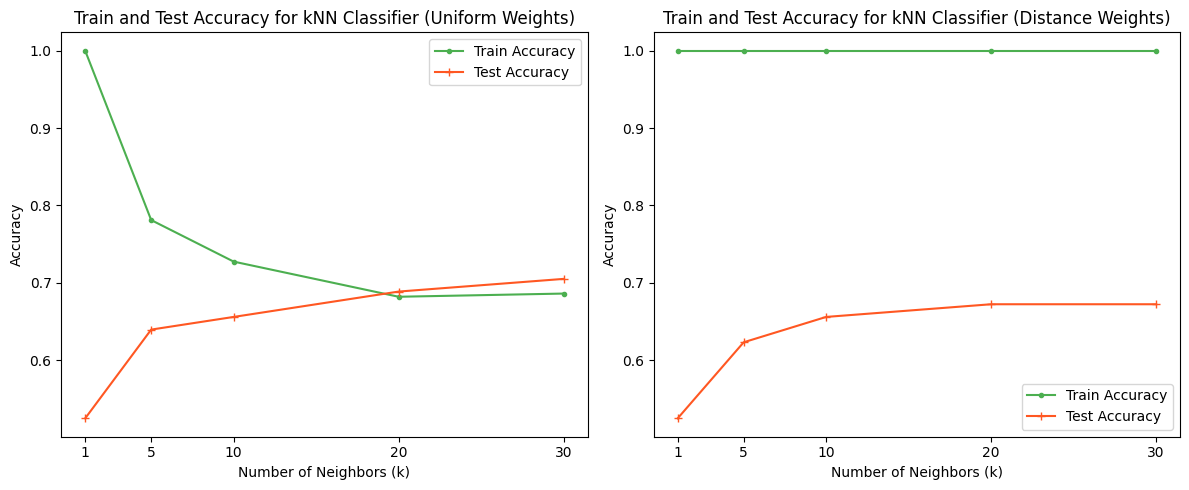

In [104]:
plt.figure(figsize=(12, 5))

train_color = "#4caf50"  
test_color = "#ff5722"   

for i, weight in enumerate(weights):
    plt.subplot(1, 2, i + 1)
    plt.plot(K_VALUES, train_accuracies[i], label = "Train Accuracy", marker = ".", color = train_color)
    plt.plot(K_VALUES, test_accuracies[i], label = "Test Accuracy", marker = "+",  color = test_color)
    plt.title(f"Train and Test Accuracy for kNN Classifier ({weight.capitalize()} Weights)")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(K_VALUES)

plt.tight_layout()
plt.show()

b. [1.5v] **Explain the impact of increasing the neighbors on the generalization ability of the models.**

In the uniform weights case (left plot), when k = 1, the model overfits the training data, resulting in near-perfect training accuracy but lower test accuracy. As k increases, the test accuracy improves steadily and becomes close to the training accuracy around k = 20. However, after this point, the training accuracy continues to drop and becomes lower than the test accuracy, indicating that the model may be underfitting. This happens because with a large number of neighbors, the model smooths out the decision boundary too much, making it less effective at capturing details in the training data.

In the distance weights case (right plot), the training accuracy remains constant and very high across all values of k, indicating that the model fits the training data closely. The test accuracy steadily improves as k increases and plateaus around k = 20, where it reaches stable generalization performance. Beyond this point, further increases in k do not significantly change the test accuracy, as the model appropriately assigns more weight to closer neighbors, minimizing the influence of distant, less relevant points. This allows the model to generalize well even with larger values of k, without noticeable underfitting.

### 3) [1.5V]

**Considering the unique properties of the `heart-disease.csv` dataset, identify two possible difficulties of the Naïve Bayes model used in the previous exercises when learning from the given dataset.**

Naïve Bayes assumes that all features are conditionally independent given the class label. However, in the context of heart disease, many risk factors — such as cholesterol levels, blood pressure, and age — can be correlated. For example, high blood pressure often correlates with high cholesterol, and both are significant risk factors for heart disease. This violation of the independence assumption can lead to suboptimal model performance, as the Naïve Bayes model may fail to accurately capture the relationships among predictors, resulting in less effective classification of heart disease cases.

Additionally, the heart disease dataset includes both categorical variables (e.g., chest pain type) and continuous variables (e.g., age, cholesterol levels). Naïve Bayes is generally more effective with categorical data and operates under the assumption that continuous features follow a Gaussian distribution. However, if these continuous features deviate from normality — an occurrence that is common in medical datasets — the model's predictions may become inaccurate. This can adversely affect its performance in classifying heart disease cases, as the model may not adequately represent the underlying distributions of the continuous features.